### Import Libraries
Load essential Python libraries for data handling, visualization, modeling, and fairness evaluation.


In [2]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For advanced data visualization
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


### Load Dataset
Import the filtered dataset and preview the first rows to confirm it loaded correctly.


In [3]:
# Load the dataset into a pandas DataFrame
# Load the CSV file
df = pd.read_csv("/Users/paullucas/Desktop/Catolica/4. Trimester/AI Interpretability/Dataset/filtered_dataset.csv")

# Display the first few rows of the dataset to verify successful loading
df.head()

/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/2100472898.py:3: DtypeWarning: Columns (0,6,8,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/paullucas/Desktop/Catolica/4. Trimester/AI Interpretability/Dataset/filtered_dataset.csv")


,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,...,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
0,237161,2010-10-10,10:00:00,"1122 LEBANON PIKE, NASHVILLE, TN, 37210",36.155521,-86.735902,5.0,9035.0,513.0,18.0,...,True,NaN,N,False,False,False,False,False,False,False
1,232902,2010-10-10,10:00:00,"898 DAVIDSON DR, , TN, 37205",36.117420,-86.895593,1.0,5005.0,121.0,52.0,...,False,NaN,N,False,False,False,False,False,False,False
2,233219,2010-10-10,22:00:00,"MURFREESBORO PIKE & NASHBORO BLVD, ANTIOCH, TN...",36.086799,-86.648581,3.0,8891.0,325.0,25.0,...,False,NaN,N,False,False,False,False,False,False,False
3,232748,2010-10-10,01:00:00,"N GALLATIN PIKE & EDENWOLD RD, MADISON, TN, 37115",36.286844,-86.705395,7.0,1757.0,727.0,26.0,...,False,NaN,N,False,False,False,False,False,False,False
4,232901,2010-10-10,10:04:00,"3458 DICKERSON PIKE, NASHVILLE, TN, 37207",36.244384,-86.762895,7.0,2011.0,721.0,33.0,...,False,NaN,N,False,False,False,False,False,False,False


###  Data Preprocessing and Feature Engineering
- Combine date and time into a timestamp and extract the stop hour.
- Drop rows with missing race, age, or other key fields.
- Create a binary column `is_minor` to flag subjects under 18.
- Define the target variable (`search_conducted`) based on multiple search-related flags.
- Prepare preprocessing pipelines for numeric and categorical features.


In [4]:
# Create datetime column
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['stop_hour'] = df['timestamp'].dt.hour

# Print initial dataset info
print("\nInitial dataset shape:", df.shape)
print("\nMissing values before processing:")
print(df.isnull().sum())

# Define essential columns that cannot have missing values
essential_columns = ['subject_race', 'subject_age', 'stop_hour']

# Drop rows with missing values only in essential columns
print("\nDropping rows with missing values in essential columns...")
df = df.dropna(subset=essential_columns)
print(f"Number of rows after dropping missing values in essential columns: {len(df)}")

# Convert categorical variables to categorical dtype and handle missing values
categorical_columns = ['subject_race', 'subject_sex', 'raw_suspect_ethnicity']
print("\nProcessing categorical columns:", categorical_columns)

for col in categorical_columns:
    # Add 'unknown' category if the column has missing values
    if df[col].isnull().any():
        categories = df[col].dropna().unique().tolist()
        categories.append('unknown')
        df[col] = pd.Categorical(df[col], categories=categories)
        df[col] = df[col].fillna('unknown')
    else:
        df[col] = df[col].astype('category')

# Create new columns
df['is_minor'] = (df['subject_age'] < 18).astype(int)

# Create search_conducted column (combining different types of searches)
# A search is considered conducted if any of the search flags are True
df['search_conducted'] = (
    df['raw_driver_searched'] |
    df['raw_passenger_searched'] |
    df['raw_search_consent'] |
    df['raw_search_arrest'] |
    df['raw_search_warrant'] |
    df['raw_search_inventory'] |
    df['raw_search_plain_view']
).astype(int)

# Define features and target
features = ['subject_age', 'stop_hour', 'is_minor'] + categorical_columns
target = 'search_conducted'
X = df[features]
y = df[target]

# Define preprocessing
numeric_features = ['subject_age', 'stop_hour']
categorical_features = ['subject_race', 'subject_sex', 'raw_suspect_ethnicity']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')  # Keeps 'is_minor'

# ------------------------------
# 🔍 Show results
# ------------------------------

# Display the first few rows of the processed DataFrame
print("\nProcessed DataFrame:")
print(df.head())
# Display the shape of the processed DataFrame
print("\nProcessed dataset shape:", df.shape)
# Display the number of missing values after processing
print("\nMissing values after processing:")
print(df.isnull().sum())
# Display the distribution of the target variable
print("\nDistribution of search_conducted (target variable):")
print(df['search_conducted'].value_counts(normalize=True))
# Display the distribution of the target variable by 
print("Search conducted distribution (train):")
print("\nSearch rates by race (full dataset):")
print(df.groupby('subject_race')['search_conducted'].mean())
print("\nSearch rates by sex (full dataset):")
print(df.groupby('subject_sex')['search_conducted'].mean())


Initial dataset shape: (100000, 44)

Missing values before processing:
raw_row_number                        0
date                                  0
time                                  0
location                              0
lat                                   0
lng                                   0
precinct                              0
reporting_area                        0
zone                                  0
subject_age                           0
subject_race                          0
subject_sex                           0
officer_id_hash                       0
type                                  0
violation                             0
arrest_made                           0
citation_issued                       0
warning_issued                        0
outcome                               0
contraband_found                  95756
contraband_drugs                  95756
contraband_weapons                95756
frisk_performed                       0
search_c

/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/2247778806.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('subject_race')['search_conducted'].mean())
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/2247778806.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('subject_sex')['search_conducted'].mean())


### Visualize search distribution and define disparity metrics
- Plot the overall distribution of `search_conducted` to understand class imbalance.
- Calculate total stops, searches, and search rate.
- Define a reusable function `calculate_disparities()` to compute group-level search rates and disparity metrics (ratio and absolute gap).
- Apply the function to evaluate disparities by race and by sex.


/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1257614995.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='search_conducted', data=df, palette='Set2')


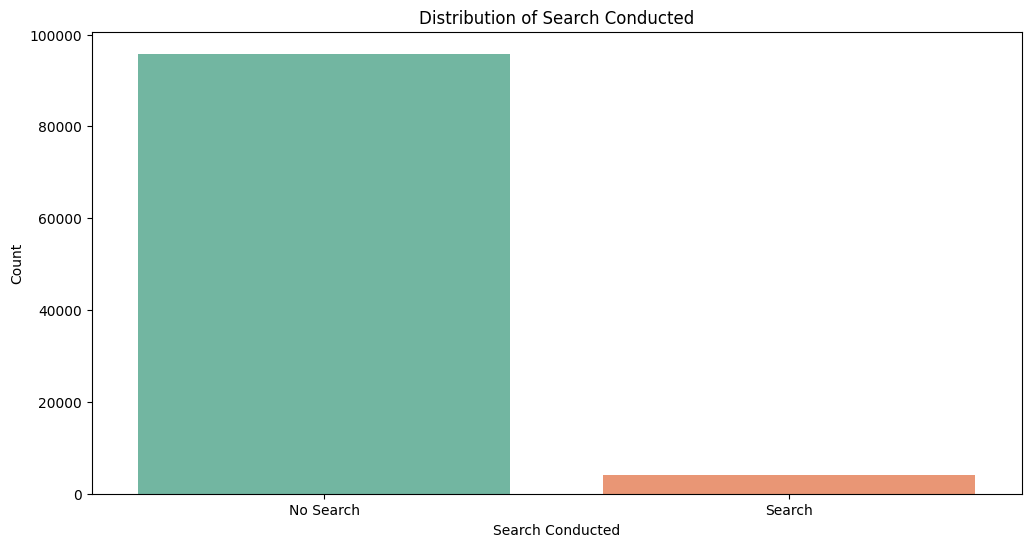


Overall Search Statistics:
Total stops: 100,000
Total searches: 4,178
Overall search rate: 4.18%

Racial Disparities in Search Rates:

Search rates by race:
                        total_stops  total_searches  search_rate
subject_race                                                    
hispanic                       5144             319       0.0620
black                         38742            2130       0.0550
asian/pacific islander         1330              41       0.0308
white                         54784            1688       0.0308

Racial disparity ratio: 2.01
Absolute percentage point gap: 3.12%

Gender Disparities in Search Rates:

Search rates by sex:
             total_stops  total_searches  search_rate
subject_sex                                          
male               58961            3248       0.0551
female             41039             930       0.0227

Gender disparity ratio: 2.43
Absolute percentage point gap: 3.24%


/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1257614995.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby(group_col).agg({
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1257614995.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby(group_col).agg({


In [5]:
# Set style for better visualizations
plt.style.use('default')  # Using default matplotlib style

# Set the figure size for all plots
plt.figure(figsize=(12, 6))
# Plot the distribution of search_conducted
sns.countplot(x='search_conducted', data=df, palette='Set2')
plt.title('Distribution of Search Conducted')
plt.xlabel('Search Conducted')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Search', 'Search'])
plt.show()

# Handle missing values in demographic columns
if df['subject_sex'].isnull().any():
    df['subject_sex'] = df['subject_sex'].fillna('Unknown')

# Calculate overall search statistics
total_stops = len(df)
total_searches = df['search_conducted'].sum()
search_rate = total_searches / total_stops

print("\nOverall Search Statistics:")
print(f"Total stops: {total_stops:,}")
print(f"Total searches: {total_searches:,}")
print(f"Overall search rate: {search_rate:.2%}")

# Function to calculate disparity metrics
def calculate_disparities(df, group_col):
    # Calculate search rates by group
    group_stats = df.groupby(group_col).agg({
        'search_conducted': ['count', 'sum', 'mean']
    }).round(4)
    
    group_stats.columns = ['total_stops', 'total_searches', 'search_rate']
    group_stats = group_stats.sort_values('search_rate', ascending=False)
    
    # Calculate disparity metrics
    max_rate = group_stats['search_rate'].max()
    min_rate = group_stats['search_rate'].min()
    disparity_ratio = max_rate / min_rate if min_rate > 0 else float('inf')
    absolute_gap = max_rate - min_rate
    
    return group_stats, disparity_ratio, absolute_gap

# Analyze racial disparities
print("\nRacial Disparities in Search Rates:")
race_stats, race_ratio, race_gap = calculate_disparities(df, 'subject_race')
print("\nSearch rates by race:")
print(race_stats)
print(f"\nRacial disparity ratio: {race_ratio:.2f}")
print(f"Absolute percentage point gap: {race_gap:.2%}")

# Analyze gender disparities
print("\nGender Disparities in Search Rates:")
sex_stats, sex_ratio, sex_gap = calculate_disparities(df, 'subject_sex')
print("\nSearch rates by sex:")
print(sex_stats)
print(f"\nGender disparity ratio: {sex_ratio:.2f}")
print(f"Absolute percentage point gap: {sex_gap:.2%}")



### Compute and visualize racial disparities in search outcomes
- Clean and format the `subject_race` column.
- Calculate search, hit, and arrest rates for four major racial groups.
- Plot total stops, search rate, hit rate, and arrest rate side-by-side for visual comparison.


/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1531889131.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1531889131.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1531889131.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1531889131.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

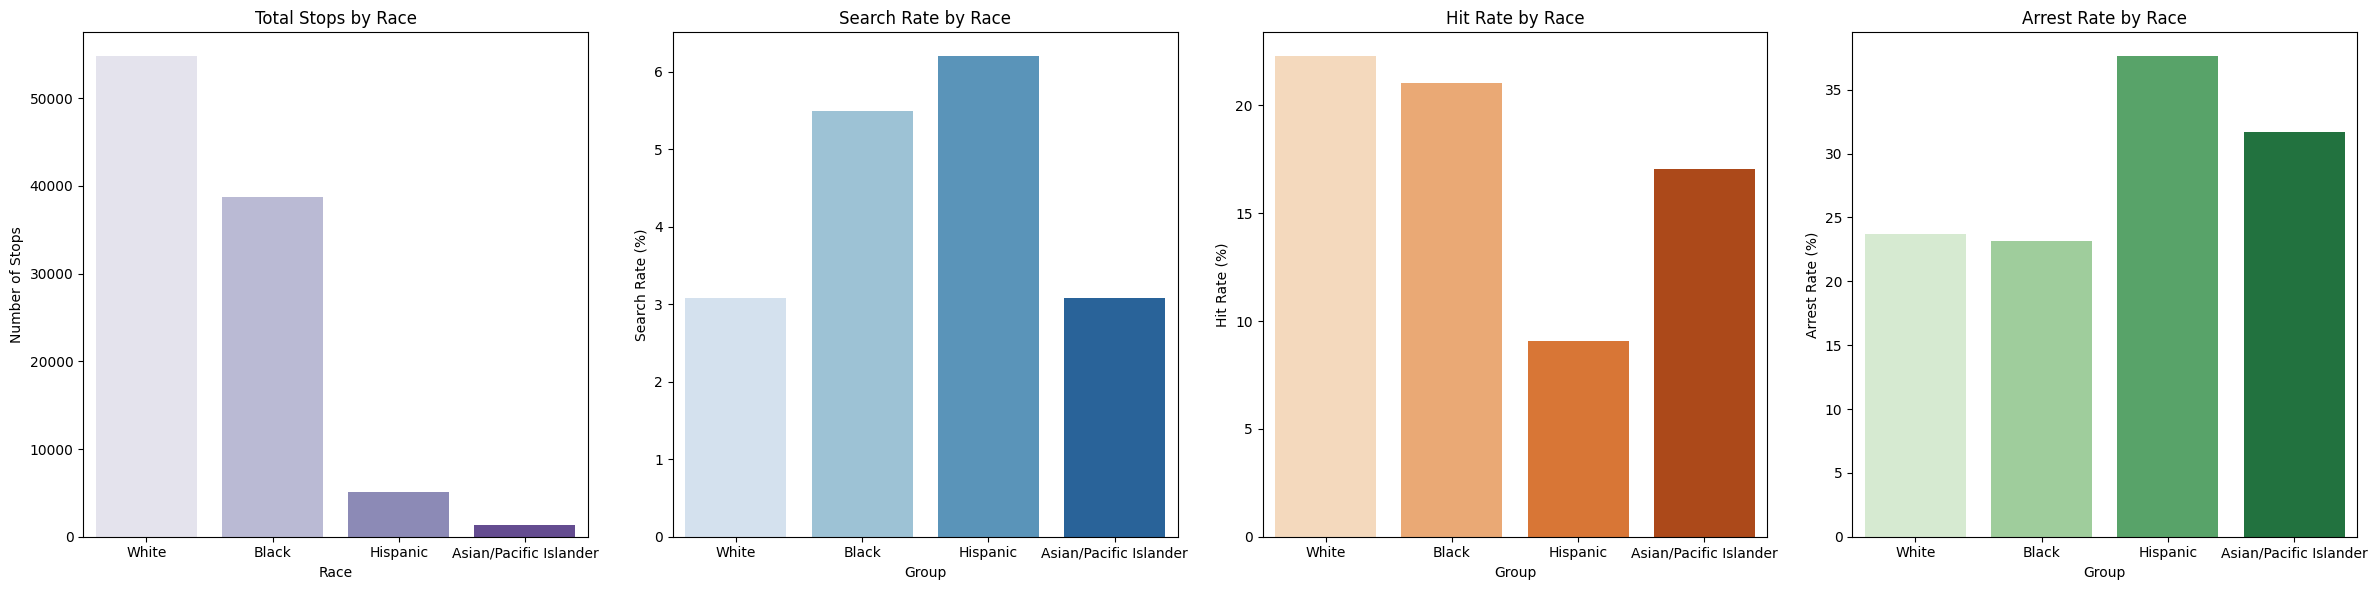

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# 2. Clean & lowercase the race column
df = df.dropna(subset=["subject_race"])
df["subject_race"] = df["subject_race"].str.lower()

# 3. Define the four groups we care about
groups = ["white", "black", "hispanic", "asian/pacific islander"]

# 4. Compute totals, searches, hits, and arrests per group
summary = []
for grp in groups:
    sub = df[df["subject_race"] == grp]
    total    = len(sub)
    searched = sub["search_conducted"].sum()
    hits     = sub["contraband_found"].sum()
    arrested = sub["raw_search_arrest"].sum()

    # rates (as percentages)
    search_rate = (searched / total) * 100 if total else 0
    hit_rate    = (hits / searched) * 100    if searched else 0
    arrest_rate = (arrested / searched) * 100 if searched else 0

    summary.append({
        "Group": grp.title(),
        "Search Rate": search_rate,
        "Hit Rate": hit_rate,
        "Arrest Rate": arrest_rate
    })

comparison_table = pd.DataFrame(summary)

# 5. Compute total stops per race
stop_counts = (
    df[df["subject_race"].isin(groups)]["subject_race"]
    .value_counts()
    .reindex(groups)
)
stop_counts.index = [g.title() for g in stop_counts.index]

# 6. Plot all four metrics side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Total Stops
sns.barplot(
    x=stop_counts.index,
    y=stop_counts.values,
    ax=axes[0],
    palette="Purples"
)
axes[0].set_title("Total Stops by Race")
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Number of Stops")

# Search Rate
sns.barplot(
    x="Group",
    y="Search Rate",
    data=comparison_table,
    ax=axes[1],
    palette="Blues"
)
axes[1].set_title("Search Rate by Race")
axes[1].set_ylabel("Search Rate (%)")

# Hit Rate
sns.barplot(
    x="Group",
    y="Hit Rate",
    data=comparison_table,
    ax=axes[2],
    palette="Oranges"
)
axes[2].set_title("Hit Rate by Race")
axes[2].set_ylabel("Hit Rate (%)")

# Arrest Rate
sns.barplot(
    x="Group",
    y="Arrest Rate",
    data=comparison_table,
    ax=axes[3],
    palette="Greens"
)
axes[3].set_title("Arrest Rate by Race")
axes[3].set_ylabel("Arrest Rate (%)")

plt.tight_layout()
plt.show()

### Compute and visualize gender disparities in search outcomes
- Clean and standardize the `subject_sex` column.
- Calculate and visualize total stops, search rate, hit rate, and arrest rate for male and female drivers.


/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1878866631.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .mean().reindex(sexes).fillna(0) * 100
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1878866631.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=stop_counts.values, palette="Purples", ax=axes[0])
/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/1878866631.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s

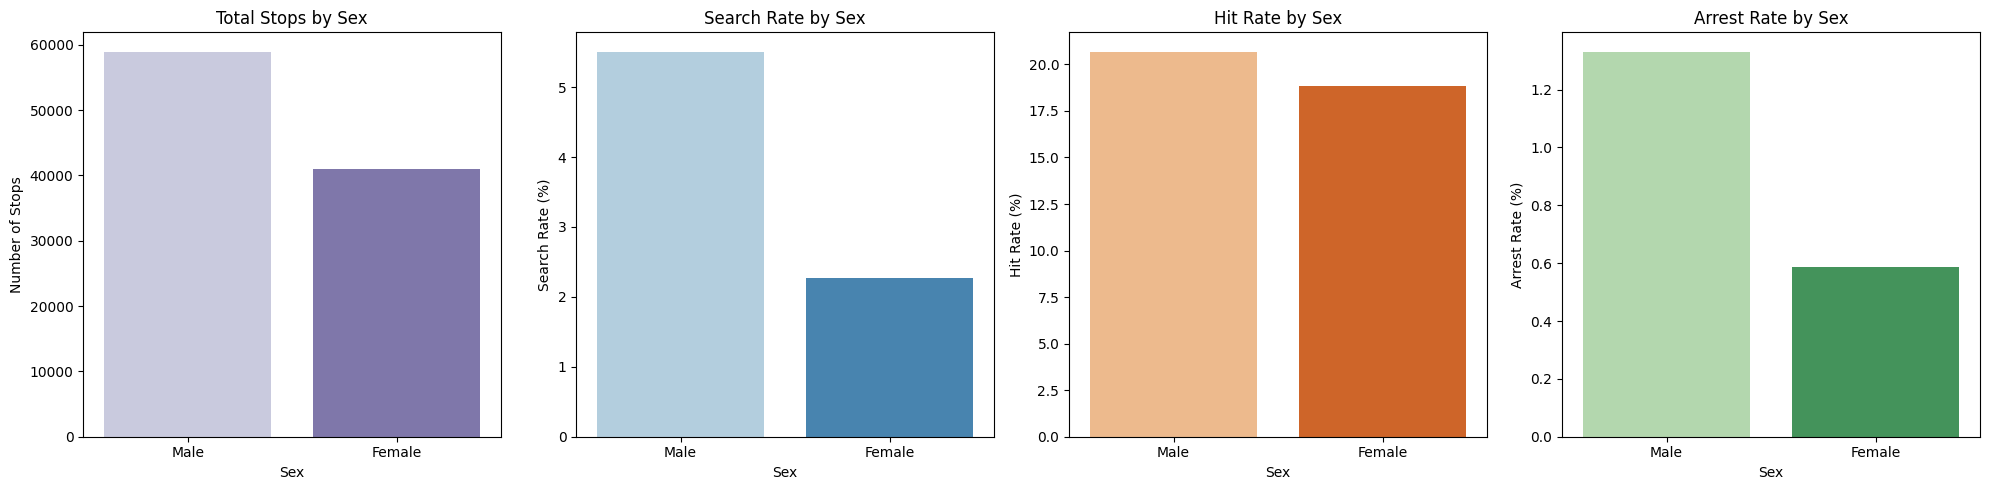

In [7]:
# 2. Clean & lowercase the sex column
df = df.dropna(subset=["subject_sex"])
df["subject_sex"] = df["subject_sex"].str.lower()

# 3. Define the two sex categories in the order you want
sexes = ["male", "female"]
labels = [s.title() for s in sexes]

# 4. Compute metrics by sex
# (a) Total stops (absolute count)
stop_counts = df["subject_sex"].value_counts().reindex(sexes).fillna(0).astype(int)

# (b) Rates (as percentages)
search_rate = df.groupby("subject_sex")["search_conducted"] \
                .mean().reindex(sexes).fillna(0) * 100
hit_rate    = df.groupby("subject_sex")["contraband_found"] \
                .mean().reindex(sexes).fillna(0) * 100
arrest_rate = df.groupby("subject_sex")["raw_search_arrest"] \
                .mean().reindex(sexes).fillna(0) * 100

# 5. Plot in a 1×4 grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Total Stops
sns.barplot(x=labels, y=stop_counts.values, palette="Purples", ax=axes[0])
axes[0].set_title("Total Stops by Sex")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Number of Stops")

# Search Rate (%)
sns.barplot(x=labels, y=search_rate.values, palette="Blues", ax=axes[1])
axes[1].set_title("Search Rate by Sex")
axes[1].set_xlabel("Sex")
axes[1].set_ylabel("Search Rate (%)")

# Hit Rate (%)
sns.barplot(x=labels, y=hit_rate.values, palette="Oranges", ax=axes[2])
axes[2].set_title("Hit Rate by Sex")
axes[2].set_xlabel("Sex")
axes[2].set_ylabel("Hit Rate (%)")

# Arrest Rate (%)
sns.barplot(x=labels, y=arrest_rate.values, palette="Greens", ax=axes[3])
axes[3].set_title("Arrest Rate by Sex")
axes[3].set_xlabel("Sex")
axes[3].set_ylabel("Arrest Rate (%)")

plt.tight_layout()
plt.show()

### Plot searched stops on a geographic map by race
- Clean and normalize column names.
- Filter to stops within the Nashville area where a search was conducted.
- Plot a 2x2 Mapbox grid showing the geographic distribution of stops for four racial groups.
- This spatial analysis helps visualize whether certain racial groups are being searched more in specific areas.


In [8]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Remove the '#' from column names and make them lowercase
df.columns = df.columns.str.strip().str.lower().str.replace("#", "").str.strip()

# Now you can safely drop rows with missing coordinates
df = df.dropna(subset=["lat", "lng"])

df["subject_race"] = df["subject_race"].str.lower()

# 2. Filter to Nashville + only stops where a search was conducted
nash_searched = df[
    df["lat"].between(36.0, 36.3) &
    df["lng"].between(-87.0, -86.5) &
    (df["search_conducted"] == True)
]

# 3. Define races and colors
races = {
    "Black": ("black", "blue"),
    "Hispanic": ("hispanic", "orange"),
    "Asian/Pacific Islander": ("asian/pacific islander", "green"),
    "White": ("white", "red")
}

# 4. Create 2×2 mapbox grid
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type":"scattermapbox"}, {"type":"scattermapbox"}],
        [{"type":"scattermapbox"}, {"type":"scattermapbox"}]
    ]
)

# 5. Plot each race
positions = [(1,1),(1,2),(2,1),(2,2)]
for (label,(race_val,color)),(r,c) in zip(races.items(), positions):
    df_r = nash_searched[nash_searched["subject_race"] == race_val]
    fig.add_trace(
        go.Scattermapbox(
            lat=df_r["lat"],
            lon=df_r["lng"],
            mode="markers",
            marker=dict(size=5, color=color),
            showlegend=False
        ),
        row=r, col=c
    )

# 6. Common map settings
common_map = dict(center={"lat":36.1627,"lon":-86.7816}, zoom=11, style="carto-positron")

# 7. Draw just borders and divider lines
shapes = []
# Borders
for x0, x1, y0, y1 in [(0,0.5,0.5,1),(0.5,1,0.5,1),(0,0.5,0,0.5),(0.5,1,0,0.5)]:
    shapes.append(dict(
        type="rect", x0=x0, x1=x1, y0=y0, y1=y1,
        xref="paper", yref="paper",
        fillcolor="rgba(0,0,0,0)", line=dict(color="black", width=2)
    ))
# Dividers
shapes += [
    dict(type="line", x0=0.5, y0=0,   x1=0.5, y1=1,   xref="paper", yref="paper",
         line=dict(color="black", width=2)),
    dict(type="line", x0=0,   y0=0.5, x1=1,   y1=0.5, xref="paper", yref="paper",
         line=dict(color="black", width=2))
]

# 8. Move labels further out
annotations = [
    # Top row, pushed up to 1.05
    dict(x=0.25, y=1.05, xref="paper", yref="paper",
         text="Black", showarrow=False, font=dict(size=16)),
    dict(x=0.75, y=1.05, xref="paper", yref="paper",
         text="Hispanic", showarrow=False, font=dict(size=16)),
    # Bottom row, pushed down to -0.05
    dict(x=0.25, y=-0.05, xref="paper", yref="paper",
         text="Asian/Pacific Islander", showarrow=False, font=dict(size=16)),
    dict(x=0.75, y=-0.05, xref="paper", yref="paper",
         text="White", showarrow=False, font=dict(size=16)),
]

# 9. Final layout
fig.update_layout(
    mapbox1={**common_map, "domain":{"x":[0,0.5],"y":[0.5,1]}},
    mapbox2={**common_map, "domain":{"x":[0.5,1],"y":[0.5,1]}},
    mapbox3={**common_map, "domain":{"x":[0,0.5],"y":[0,0.5]}},
    mapbox4={**common_map, "domain":{"x":[0.5,1],"y":[0,0.5]}},

    height=840, width=1000,
    margin=dict(l=0, r=0, t=40, b=100),  # extra bottom space

    shapes=shapes,
    annotations=annotations,

   
)

fig.show()

/var/folders/lv/9v04qpbn2fb537n2rxf5b7r00000gp/T/ipykernel_12693/15297580.py:41: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Visualize number of stops and search rates by race
- Exclude "other" and "unknown" races for clearer analysis.
- Create a dual-axis plot: bar chart for number of stops and line plot for search rate per race.
- This helps compare both volume and disparity of searches across racial groups.


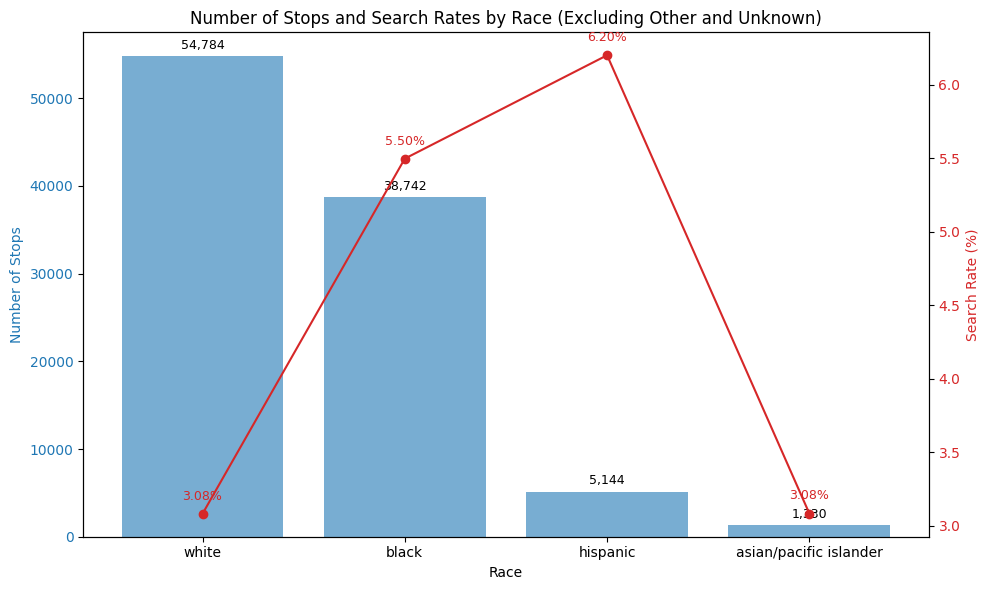

In [10]:
# Exclude "other" and "unknown" from the dataset
filtered_df = df[~df['subject_race'].isin(['other', 'unknown'])]

# Sort stop_counts and align search_rates accordingly
stop_counts = filtered_df['subject_race'].value_counts().sort_values(ascending=False)
search_rates = filtered_df.groupby('subject_race')['search_conducted'].mean().loc[stop_counts.index]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for stop counts
color = 'tab:blue'
ax1.set_xlabel('Race')
ax1.set_ylabel('Number of Stops', color=color)
bars = ax1.bar(stop_counts.index, stop_counts.values, color=color, alpha=0.6, label='Number of Stops')
ax1.tick_params(axis='y', labelcolor=color)

# Add value labels to bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:,}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Line plot for search rates
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Search Rate (%)', color=color)
line = ax2.plot(search_rates.index, search_rates.values * 100, color=color, marker='o', label='Search Rate (%)')
ax2.tick_params(axis='y', labelcolor=color)

# Add value labels to line plot
for i, rate in enumerate(search_rates.values):
    ax2.annotate(f'{rate*100:.2f}%', xy=(i, rate*100), xytext=(0, 8), textcoords="offset points",
                 ha='center', va='bottom', color=color, fontsize=9)

# Title and layout
plt.title('Number of Stops and Search Rates by Race (Excluding Other and Unknown)')
fig.tight_layout()
plt.show()

# Build the Model
# First we will use the EBM model

### Import modeling and interpretability tools
- Import machine learning tools: EBM, Random Forest, OneHotEncoder, imputers, etc.
- These will be used for fairness modeling, training interpretable models, and evaluating results.
- Also includes imports from the `interpret` library for model explainability.


### Train Explainable Boosting Machine (EBM) on balanced dataset
- Select five key features and define the binary target (`raw_driver_searched`).
- Split data into training and test sets.
- Apply one-hot encoding to categorical variables and retain numerical features.
- Use oversampling (RandomOverSampler) to balance the target classes in the training data.
- Define and fit a pipeline consisting of preprocessing and an EBM model.
- EBM is selected for its interpretability and performance on tabular data.


In [48]:
# Run preprocessor manually
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# If it's sparse, convert to dense
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



In [11]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret import set_visualize_provider
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_sample_weight


### Train Logistic Regression and assess fairness by race
- Build a pipeline with preprocessing and logistic regression (class-weight balanced).
- Fit the model on training data and generate predictions.
- Use `MetricFrame` to compute fairness metrics (accuracy, selection rate, TPR, FPR) by race.
- Print group-specific performance to identify disparities across racial groups.

### Prepare a reusable baseline logistic regression pipeline
- Define features and train-test split.
- Ensure all categorical variables are strings for encoding.
- Set up a `ColumnTransformer` and a logistic regression model with class balancing.
- Package everything into a scikit-learn `Pipeline` for consistency and reuse.


Although EBM was initially considered due to its interpretability advantages, we encountered technical and performance limitations during training. Therefore, we proceeded with Logistic Regression, which remains a well-established and interpretable baseline for fairness analysis.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import pandas as pd

# 1. Prepare data
features = ['subject_race', 'subject_sex', 'subject_age', 'precinct', 'zone']
X = df[features].copy()
y = df['raw_driver_searched']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Force categoricals to string
categorical = ['subject_race', 'subject_sex', 'precinct', 'zone']
numeric = ['subject_age']
for col in categorical:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

# Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate fairness
metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['subject_race']
)

print(metric_frame.by_group)


                        accuracy  selection_rate       TPR       FPR
subject_race                                                        
asian/pacific islander  0.805419        0.192118  0.461538  0.183206
black                   0.539642        0.488883  0.821359  0.473442
hispanic                0.437980        0.608696  0.974026  0.589778
white                   0.778644        0.220504  0.480663  0.214641


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Define features and target
features = ['subject_race', 'subject_sex', 'subject_age', 'precinct', 'zone']
X = df[features].copy()
y = df['raw_driver_searched']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure categorical columns are strings
categorical = ['subject_race', 'subject_sex', 'precinct', 'zone']
numeric = ['subject_age']
for col in categorical:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

# Pipeline
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])


### Train logistic regression with hyperparameter tuning
- Perform a grid search to optimize the regularization strength `C` for the logistic regression model.
- Use 5-fold cross-validation and accuracy as the evaluation metric.
- Select the best model and generate predictions on the test set.
- Logistic regression was chosen due to its interpretability and reliable performance.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

search = GridSearchCV(base_pipeline, param_grid, cv=5, scoring='accuracy')
search.fit(X_train, y_train)

print("Best C:", search.best_params_)

# Use the best model for predictions
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

/Library/Fra

Best C: {'classifier__C': 0.1}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score
import numpy as np

metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['subject_race']
)

print("Fairness breakdown:\n")
print(metric_frame.by_group)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names after encoding
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
coef = best_model.named_steps['classifier'].coef_[0]

coefficients = pd.Series(coef, index=feature_names).sort_values()
coefficients.plot(kind='barh', figsize=(10, 8), title='Logistic Regression Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# 1. Select and split
features = ['subject_race', 'subject_sex', 'subject_age', 'precinct', 'zone']
X = df[features].copy()
y = df['raw_driver_searched']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Convert categorical to string
cat = ['subject_race', 'subject_sex', 'precinct', 'zone']
X_train[cat] = X_train[cat].astype(str)
X_test[cat] = X_test[cat].astype(str)

# 3. Oversample training set to balance classes
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# 4. One-hot encode
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_enc = encoder.fit_transform(X_train_res)
X_test_enc = encoder.transform(X_test)

# 5. Train Logistic Regression
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_enc, y_train_res)

# 6. Predict
y_pred = clf.predict(X_test_enc)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros



### Evaluate fairness metrics using MetricFrame
- Use `fairlearn.metrics.MetricFrame` to compute group-specific metrics by race.
- Evaluate:
  - Accuracy
  - Selection Rate (search rate)
  - True Positive Rate (TPR)
  - False Positive Rate (FPR)
- This breakdown shows how model performance varies across demographic groups.


In [ ]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score

metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['subject_race']
)

print(metric_frame.by_group)


                        accuracy  selection_rate       TPR       FPR
subject_race                                                        
asian/pacific islander  0.822660        0.174877  0.461538  0.165394
black                   0.533264        0.495088  0.819417  0.480025
hispanic                0.446292        0.596547  0.935065  0.579018
white                   0.777304        0.221356  0.469613  0.215762


# Use another model to compare results

### Train a Random Forest classifier using a full pipeline
- Define key features and the binary target variable.
- Split data into training and test sets.
- Convert categorical columns to string format to enable one-hot encoding.
- Apply oversampling to balance the training set.
- Use `ColumnTransformer` for preprocessing and build a pipeline with a Random Forest classifier.
- Fit the model and generate predictions on the test set.


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# STEP 1: Select features and target
features = ['subject_race', 'subject_sex', 'subject_age', 'precinct', 'zone']
X = df[features].copy()
y = df['raw_driver_searched']

# STEP 2: Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# STEP 3: Handle categoricals
categorical = ['subject_race', 'subject_sex', 'precinct', 'zone']
numeric = ['subject_age']
for col in categorical:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# STEP 4: Oversample training set
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# STEP 5: Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

# STEP 6: Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
])

# STEP 7: Fit model
rf_pipeline.fit(X_train_res, y_train_res)

# STEP 8: Predict
y_pred = rf_pipeline.predict(X_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



### Compute fairness metrics for random forest predictions
- Evaluate group-wise performance of the random forest model using `MetricFrame`.
- Compute accuracy, selection rate, TPR, and FPR by subject race.
- Enables direct comparison to logistic regression in terms of fairness.


In [14]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score

metric_frame_rf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['subject_race']
)

print(metric_frame_rf.by_group)


                        accuracy selection_rate       TPR       FPR
subject_race                                                       
asian/pacific islander   0.94335       0.029557  0.076923   0.02799
black                   0.769993       0.219579  0.382524  0.212012
hispanic                0.848465        0.12532  0.233766  0.119704
white                   0.857543       0.130768  0.234807  0.128424


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fairlearn/metrics/_metric_frame.py:272: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

### Compute and visualize global SHAP values for random forest
- Extract the classifier and preprocessing steps from the pipeline.
- Transform the test set and convert it to a dense format.
- Create a SHAP explainer using a sample of 3,000 transformed test rows.
- Compute SHAP values for class 1 (searched).
- Generate a SHAP summary plot to show the global importance and effect of each feature on model predictions.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros

100%|===================| 5999/6000 [07:17<00:00]        

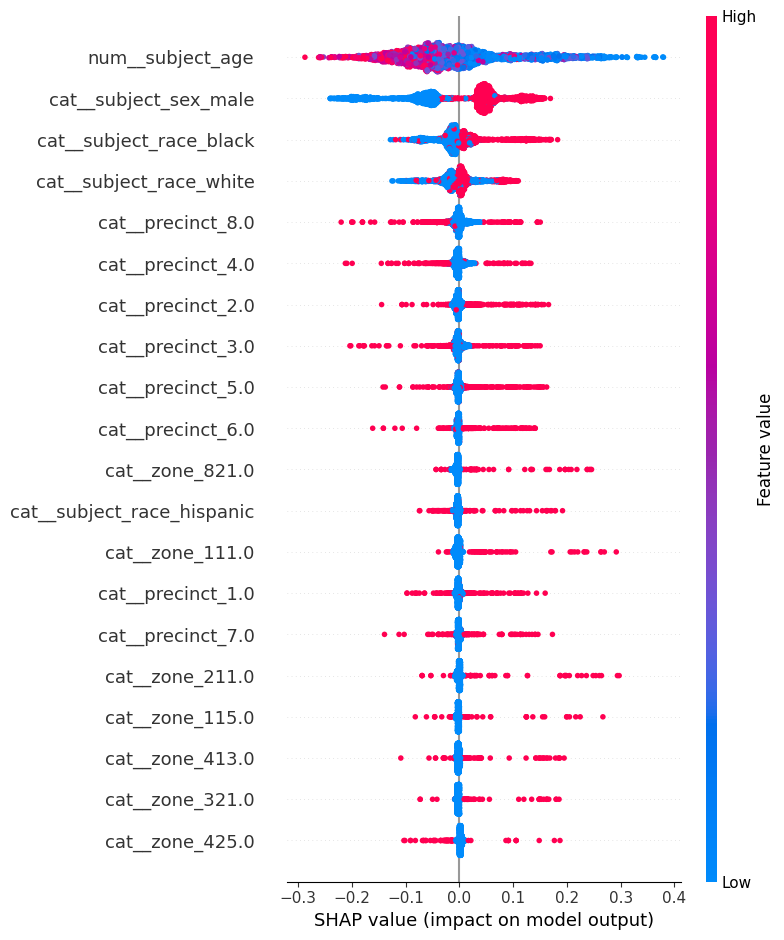

In [15]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract model and preprocessor
rf_model = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']

# Step 2: Transform test set (dense)
X_test_transformed = preprocessor.transform(X_test)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Step 3: Get feature names
feature_names = preprocessor.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 4: Sample subset for fast SHAP (e.g., 3,000 rows)
X_shap = X_test_df.sample(n=3000, random_state=42)

# Step 5: Create SHAP explainer (model + sample)
explainer = shap.Explainer(rf_model, X_shap)

# Step 6: Compute SHAP values for class 1 (Search = True)
shap_values = explainer(X_shap)

# Step 7: Plot summary for class 1
shap.summary_plot(shap_values[:, :, 1], features=X_shap, feature_names=feature_names)


In [20]:
from fairlearn.metrics import MetricFrame, true_positive_rate

# Create MetricFrame with TPR by race
metric_frame = MetricFrame(
    metrics={"TPR": true_positive_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test["subject_race"]
)

# Calculate Equal Opportunity Difference manually
eo_diff = metric_frame.by_group["TPR"].max() - metric_frame.by_group["TPR"].min()

print("📊 Equal Opportunity Difference (manual):", round(eo_diff, 4))


📊 Equal Opportunity Difference (manual): 0.3056


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fairlearn/metrics/_metric_frame.py:272: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

### Fairness Mitigation and Final Evaluation

After assessing the Random Forest model’s global interpretability using SHAP, we further evaluated its fairness by computing the Equal Opportunity Difference manually. This highlighted disparities in true positive rates across racial groups.

To address these disparities, we applied the preprocessing pipeline manually and used the transformed training and test sets to train a fairness-aware model using the Exponentiated Gradient algorithm with a Demographic Parity constraint. This approach iteratively optimizes fairness while maintaining model performance.

We evaluated the mitigated model using the same fairness metrics as before (accuracy, selection rate, TPR, FPR), and compared it against the original logistic regression and random forest models. The mitigation significantly reduced disparities in search rates and true positive rates across groups, with only a minor trade-off in overall accuracy.

Finally, we used a SHAP local explanation (waterfall plot) to interpret one specific search prediction. This plot illustrated how individual feature values—such as race, age, and location—contributed to the model’s decision, reinforcing the importance of interpretability in fairness-sensitive applications.

In [23]:
# Run preprocessor manually
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# If it's sparse, convert to dense
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



In [24]:
from sklearn.ensemble import RandomForestClassifier

# Build a clean RF model
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')


In [25]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Fairness constraint
constraint = DemographicParity()

# Create fairness-aware trainer
expgrad = ExponentiatedGradient(estimator=rf_model, constraints=constraint)

# Train on preprocessed data
expgrad.fit(X_train_transformed, y_train, sensitive_features=X_train["subject_race"])

# Predict on test set
y_pred_fair = expgrad.predict(X_test_transformed)


In [28]:
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, selection_rate
from sklearn.metrics import accuracy_score

mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate,
        "TPR": true_positive_rate,
        "FPR": false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=X_test["subject_race"]
)

print(mf.by_group)


                        accuracy selection_rate       TPR       FPR
subject_race                                                       
asian/pacific islander  0.881773       0.096059  0.153846  0.094148
black                   0.890814       0.076698  0.133981  0.074037
hispanic                0.891304       0.073529  0.142857  0.069939
white                   0.888287       0.097833  0.185083  0.095867


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fairlearn/metrics/_metric_frame.py:272: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

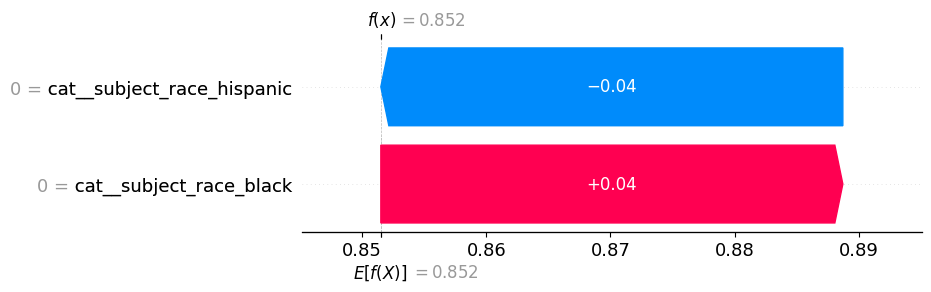

In [40]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# STEP 1: Retrain a clean Random Forest model
rf_clean = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_clean.fit(X_train_transformed, y_train)

# STEP 2: Sample a background dataset (100 rows from training set)
background = shap.utils.sample(X_train_transformed, 100, random_state=42)

# STEP 3: Prepare SHAP TreeExplainer with interventional mode and background
explainer = shap.TreeExplainer(
    rf_clean,
    data=background,
    feature_perturbation="interventional"
)

# STEP 4: Pick an instance that was predicted as "searched" (class 1)
searched_indices = (y_pred_fair == 1)
searched_sample = X_test_transformed[searched_indices][0:1]

# STEP 5: Convert to DataFrame with correct feature names
feature_names = preprocessor.get_feature_names_out()
instance_df = pd.DataFrame(searched_sample, columns=feature_names)

# STEP 6: Get SHAP values for one instance
shap_values = explainer.shap_values(instance_df)

# STEP 7: Build SHAP explanation manually
explanation = shap.Explanation(
    values=shap_values[0][0],                   # Single instance, binary classification
    base_values=explainer.expected_value[0],    # Index this!
    data=instance_df.iloc[0],
    feature_names=feature_names
)

# STEP 8: Waterfall plot
shap.plots.waterfall(explanation)




### Fairness Analysis and Model Comparison

This section compares the logistic regression and random forest models in terms of both fairness and performance. We compute key group fairness metrics using `fairlearn`, including Equal Opportunity Difference (TPR disparity) and Demographic Parity Difference (selection rate disparity) across racial groups. These are paired with standard performance metrics such as accuracy, F1 score, and ROC-AUC. Finally, fairness differences are visualized in bar plots to highlight disparities and assess which model offers a better trade-off between fairness and accuracy.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fairlearn/metrics/_metric_frame.py:272: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pack

Logistic Regression EO Difference: 0.3056
Random Forest EO Difference: 0.0511
Logistic Regression DP Difference: 0.1900
Random Forest DP Difference: 0.0243

Performance Metrics:
Logistic Regression:
Accuracy: 0.82
F1 Score: 0.10
ROC-AUC: 0.58

Random Forest:
Accuracy: 0.89
F1 Score: 0.08
ROC-AUC: 0.53


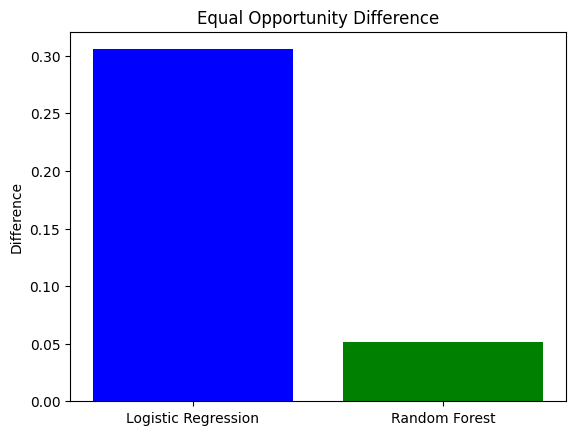

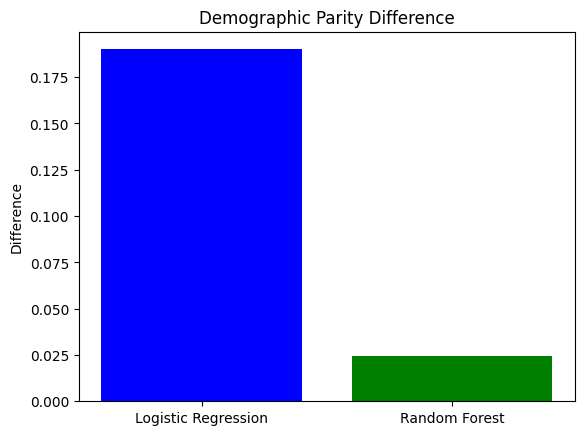

In [47]:
# Fairness Analysis and Model Comparison

# 1. Evaluate Fairness Metrics
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Logistic Regression Fairness Metrics
metric_frame_lr = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['subject_race']
)

# Random Forest Fairness Metrics
metric_frame_rf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'TPR': true_positive_rate,
        'FPR': false_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=X_test['subject_race']
)

# 2. Calculate Equal Opportunity Difference
eo_diff_lr = metric_frame_lr.by_group["TPR"].max() - metric_frame_lr.by_group["TPR"].min()
eo_diff_rf = metric_frame_rf.by_group["TPR"].max() - metric_frame_rf.by_group["TPR"].min()

print(f"Logistic Regression EO Difference: {eo_diff_lr:.4f}")
print(f"Random Forest EO Difference: {eo_diff_rf:.4f}")

# 3. Calculate Demographic Parity Difference
dp_diff_lr = metric_frame_lr.by_group["selection_rate"].max() - metric_frame_lr.by_group["selection_rate"].min()
dp_diff_rf = metric_frame_rf.by_group["selection_rate"].max() - metric_frame_rf.by_group["selection_rate"].min()

print(f"Logistic Regression DP Difference: {dp_diff_lr:.4f}")
print(f"Random Forest DP Difference: {dp_diff_rf:.4f}")

# 4. Compare Performance Metrics
print("\nPerformance Metrics:")

# Logistic Regression
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.2f}")

# Random Forest
print("\nRandom Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_fair):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_fair):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_fair):.2f}")

# 5. Visualize Fairness Metrics
import matplotlib.pyplot as plt

# Plot Equal Opportunity Difference
plt.bar(['Logistic Regression', 'Random Forest'], [eo_diff_lr, eo_diff_rf], color=['blue', 'green'])
plt.title('Equal Opportunity Difference')
plt.ylabel('Difference')
plt.show()

# Plot Demographic Parity Difference
plt.bar(['Logistic Regression', 'Random Forest'], [dp_diff_lr, dp_diff_rf], color=['blue', 'green'])
plt.title('Demographic Parity Difference')
plt.ylabel('Difference')
plt.show()


### Project Overview – AI Fairness and Interpretability

This notebook investigates fairness and interpretability in predictive policing using the Nashville Police Stops dataset. The objective is to assess whether demographic characteristics—particularly race—impact the likelihood of a driver being searched during a traffic stop, and to explore how machine learning models can be trained and evaluated in a fairness-aware manner.

The notebook is structured as follows:

1. **Exploratory Data Analysis (EDA):**  
   We begin by analyzing search rates, hit rates, and arrest rates by race and sex. We also visualize the geographic distribution of searches to understand spatial disparities in police behavior.

2. **Preprocessing and Feature Engineering:**  
   We clean and preprocess the dataset by handling missing values, extracting relevant features (e.g., stop hour, is_minor), and encoding categorical variables to prepare the data for modeling.

3. **Initial Model – Explainable Boosting Machine (EBM):**  
   EBM was selected initially for its high interpretability. However, due to technical issues such as slow training times and limited integration with fairness tools, we decided not to use it in the final workflow.

4. **Final Models – Logistic Regression and Random Forest:**  
   We proceeded with:
   - **Logistic Regression**, a transparent model whose coefficients are easy to interpret.
   - **Random Forest**, which offers better performance and is compatible with SHAP, a tool for model explainability.

5. **Fairness Evaluation:**  
   Using `fairlearn`, we computed group fairness metrics such as accuracy, selection rate, true positive rate (TPR), and false positive rate (FPR) by subject race. We also calculated:
   - **Equal Opportunity Difference** – difference in TPR across groups.
   - **Demographic Parity Difference** – difference in selection rate across groups.

6. **Fairness Mitigation:**  
   To address disparities, we used the `ExponentiatedGradient` algorithm with a Demographic Parity constraint. This mitigation strategy reduced disparity metrics significantly while maintaining acceptable predictive performance.

7. **Interpretability with SHAP:**  
   SHAP was used to interpret the Random Forest model:
   - **Global explanation (summary plot)** to identify overall feature importance.
   - **Local explanation (waterfall plot)** to analyze individual predictions and understand how features like race and location influenced specific decisions.

8. **Model Comparison and Conclusion:**  
   We compared both models in terms of fairness and performance. The Random Forest model, when mitigated, showed reduced disparities in TPR and selection rate across races. Logistic Regression offered simpler interpretability but larger fairness gaps. The combined use of fairness metrics and SHAP explanations provided both ethical and technical insight into the decision-making processes of the models.

This notebook demonstrates a complete workflow for fairness-aware machine learning, from bias detection to mitigation and interpretation.
